# Capstone Presentation

I will be investigating a Kaggle dataset gathered from a [Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment). It was compiled by 2 Columbia Business School professors for their paper "Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment", which they wrote in an effort to understand what influences "love at first sight".

Data was gathered from participants in experimental speed dating events 2002 - 2004. During the events, the attendees had a 4-minute "first date" with every other participant of the opposite sex. At the end of their 4 minutes, participants rated their date on 6 attributes: 

- Attractiveness
- Sincerity
- Intelligence
- Fun
- Ambition
- Shared Interests

The dataset also includes questionnaire data gathered from participants at different points in the process (i.e. demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information). 

My goal is to be able to take this questionnaire data (namely each person's preferences, ratings, thoughts on the opposite sex's preferences, thoughts on how he/she measures up to opposite sex's preferences, etc.) to predict whether 2 people will be a match.

## Explore Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

raw_data = pd.read_csv('./data/speed_dating.csv', encoding="ISO-8859-1")
print(list(raw_data.columns))
print(raw_data.shape[0], 'Rows')
print(raw_data.shape[1], 'Columns')
raw_data.head()

['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'partner', 'pid', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race', 'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date', 'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'de

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [2]:
def get_total_possible_partners(wave):
    if wave in [1, 5, 8, 17]:
        return 10
    elif wave in [2]:
        return 19
    elif wave in [4]:
        return 18
    elif wave in [6]:
        return 5
    elif wave in [7]:
        return 16
    elif wave in [9]:
        return 20
    elif wave in [10]:
        return 9
    elif wave in [11]:
        return 21
    elif wave in [18]:
        return 6
    elif wave in [21]:
        return 22
    # weird ones
    elif wave in [3, 13]:
        return 9.5
    elif wave in [12]:
        return 14.5 / 2
    elif wave in [14]:
        return 19
    elif wave in [15]:
        return 18.5
    elif wave in [16]:
        return 7
    elif wave in [17]:
        return 12
    elif wave in [19]:
        return 15.5
    elif wave in [20]:
        return 7

raw_data['total_partners'] = raw_data['wave'].apply(get_total_possible_partners)

In [3]:
def get_col_descriptions(df):
    cols_many_nans = []
    for idx, col in enumerate(df.columns):
        num_uniq = len(df[col].unique())
        formatted_msg = '{}. {} – {} uniq vals'.format(idx + 1, col, num_uniq)
        
        if df[col].isnull().sum() > 0:
            num_nans = df[col].isnull().sum()
            percent_nans = round(num_nans / df.shape[0] * 100, 2)
#             print(formatted_msg + '; {} NaNs ({}%)'.format(num_nans, percent_nans))
            if percent_nans > 50:
                cols_many_nans.append(col)
#         else:
#             print(formatted_msg)
#     print('\n{} columns with 50+% NaNs: {}'.format(len(cols_many_nans), cols_many_nans))
    return cols_many_nans

cols_many_nans = get_col_descriptions(raw_data)

## Clean Data

In [143]:
# Normalize columns of interest on appropriate scale (e.g. 'rate on a scale of 1 to x')
df = raw_data.copy()

# TODO: CONSOLIDATING ROWS FOR SAME DATES
my_prefs = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
partners_prefs = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']
guess_opp_sex_prefs = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
guess_my_sex_prefs = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
guess_my_rating = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
ratings_for_me = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o']
ratings_for_partner = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']

df[my_prefs] = raw_data[my_prefs].apply(lambda x: round(x / 100, 2))
df[partners_prefs] = raw_data[partners_prefs].apply(lambda x: round(x / 100, 2))
df[guess_opp_sex_prefs] = raw_data[guess_opp_sex_prefs].apply(lambda x: round(x / 100, 2))
df[guess_my_sex_prefs] = raw_data[guess_my_sex_prefs].apply(lambda x: round(x / 100, 2))
df[guess_my_rating] = raw_data[guess_my_rating].apply(lambda x: round(x / 10, 2))
df[ratings_for_me] = raw_data[ratings_for_me].apply(lambda x: round(x / 10, 2))
df[ratings_for_partner] = raw_data[ratings_for_partner].apply(lambda x: round(x / 10, 2))
df['satis_2'] = raw_data['satis_2'].apply(lambda x: round(x / 10, 2))
df['imprace'] = raw_data['imprace'].apply(lambda x: round(x / 10, 2))
df['imprelig'] = raw_data['imprelig'].apply(lambda x: round(x / 10, 2))

diff_my_prefs_and_ratings = []
diff_partners_prefs_and_ratings = []

for idx in range(len(my_prefs)):
    diff_col_name = 'diff_my_' + ratings_for_partner[idx]
    diff_my_prefs_and_ratings.append(diff_col_name)
    df[diff_col_name] = df[my_prefs[idx]] - df[ratings_for_partner[idx]]

for idx in range(len(partners_prefs)):
    diff_col_name = 'diff_partners_' + ratings_for_me[idx]
    diff_partners_prefs_and_ratings.append(diff_col_name)
    df[diff_col_name] = df[partners_prefs[idx]] - df[ratings_for_me[idx]]

df[my_prefs + ratings_for_partner + diff_my_prefs_and_ratings].head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr,sinc,intel,fun,amb,shar,like,diff_my_attr,diff_my_sinc,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar
0,0.15,0.2,0.2,0.15,0.15,0.15,0.6,0.9,0.7,0.7,0.6,0.5,0.7,-0.45,-0.7,-0.5,-0.55,-0.45,-0.35
1,0.15,0.2,0.2,0.15,0.15,0.15,0.7,0.8,0.7,0.8,0.5,0.6,0.7,-0.55,-0.6,-0.5,-0.65,-0.35,-0.45
2,0.15,0.2,0.2,0.15,0.15,0.15,0.5,0.8,0.9,0.8,0.5,0.7,0.7,-0.35,-0.6,-0.7,-0.65,-0.35,-0.55
3,0.15,0.2,0.2,0.15,0.15,0.15,0.7,0.6,0.8,0.7,0.6,0.8,0.7,-0.55,-0.4,-0.6,-0.55,-0.45,-0.65
4,0.15,0.2,0.2,0.15,0.15,0.15,0.5,0.6,0.7,0.7,0.6,0.6,0.6,-0.35,-0.4,-0.5,-0.55,-0.45,-0.45


In [144]:
def is_field_cd_same(row):
    partners_row = df[df['iid'] == row['pid']]
    if len(partners_row) > 0:
        partners_row = partners_row.iloc[0,:]
        return 1 if row['field_cd'] == partners_row['field_cd'] else 0
    else:
        return float('NaN')
    
def is_career_c_same(row):
    partners_row = df[df['iid'] == row['pid']]
    if len(partners_row) > 0:
        partners_row = partners_row.iloc[0,:]
        return 1 if row['career_c'] == partners_row['career_c'] else 0
    else:
        return float('NaN')

def get_match_perc(row):
    return row['match_es'] / row['total_partners']

def older_male(row):
    return 1 if (row['age'] - row['age_o'] > 0) and (row['gender'] == 1) else 0

df['older_male'] = df.apply(older_male, axis=1)
df['field_cd_same'] = df.apply(is_field_cd_same, axis=1)
df['career_c_same'] = df.apply(is_career_c_same, axis=1)
df['match_es_perc'] = df.apply(get_match_perc, axis=1)
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,older_male,field_cd_same,career_c_same,match_es_perc
0,1,1.0,0,1,1,1,10,7,NaN,4,...,-0.25,-0.60,-0.60,-0.60,-0.80,-0.55,0,0.0,0.0,0.4
1,1,1.0,0,1,1,1,10,7,NaN,3,...,-0.10,-0.80,-1.00,-0.30,-0.70,-0.50,0,1.0,0.0,0.4
2,1,1.0,0,1,1,1,10,7,NaN,10,...,-0.81,-0.82,-0.81,-0.82,-0.86,-0.88,0,1.0,0.0,0.4
3,1,1.0,0,1,1,1,10,7,NaN,5,...,-0.40,-0.75,-0.75,-0.40,-0.85,-0.75,0,1.0,0.0,0.4
4,1,1.0,0,1,1,1,10,7,NaN,7,...,-0.50,-0.60,-0.70,-0.50,-0.80,-0.50,0,1.0,0.0,0.4


In [145]:
# Drop cols with more than 50% NaNs
df = df.drop(labels=cols_many_nans, axis=1)

# Drop id cols
id_cols = ['iid', 'id', 'idg', 'pid']
df = df.drop(labels=id_cols, axis=1)

df.head()

,gender,condtn,wave,round,position,positin1,order,partner,match,int_corr,...,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,older_male,field_cd_same,career_c_same,match_es_perc
0,0,1,1,10,7,NaN,4,1,0,0.14,...,-0.25,-0.60,-0.60,-0.60,-0.80,-0.55,0,0.0,0.0,0.4
1,0,1,1,10,7,NaN,3,2,0,0.54,...,-0.10,-0.80,-1.00,-0.30,-0.70,-0.50,0,1.0,0.0,0.4
2,0,1,1,10,7,NaN,10,3,1,0.16,...,-0.81,-0.82,-0.81,-0.82,-0.86,-0.88,0,1.0,0.0,0.4
3,0,1,1,10,7,NaN,5,4,1,0.61,...,-0.40,-0.75,-0.75,-0.40,-0.85,-0.75,0,1.0,0.0,0.4
4,0,1,1,10,7,NaN,7,5,1,0.21,...,-0.50,-0.60,-0.70,-0.50,-0.80,-0.50,0,1.0,0.0,0.4


In [146]:
cols_with_nans = list(df.columns[df.isna().any()])
cols_without_nans = list(set(df.columns) - set(cols_with_nans))
print('Columns with NaNs:\n', ', '.join(cols_with_nans))
print('\nColumns without NaNs:\n', ', '.join(cols_without_nans))

Columns with NaNs:
 positin1, int_corr, age_o, race_o, pf_o_att, pf_o_sin, pf_o_int, pf_o_fun, pf_o_amb, pf_o_sha, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o, like_o, prob_o, met_o, age, field, field_cd, undergra, race, imprace, imprelig, from, zipcode, income, goal, date, go_out, career, career_c, sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga, exphappy, attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1, attr4_1, sinc4_1, intel4_1, fun4_1, amb4_1, shar4_1, attr2_1, sinc2_1, intel2_1, fun2_1, amb2_1, shar2_1, attr3_1, sinc3_1, fun3_1, intel3_1, amb3_1, attr5_1, sinc5_1, intel5_1, fun5_1, amb5_1, attr, sinc, intel, fun, amb, shar, like, prob, met, match_es, satis_2, length, numdat_2, attr1_2, sinc1_2, intel1_2, fun1_2, amb1_2, shar1_2, attr4_2, sinc4_2, intel4_2, fun4_2, amb4_2, shar4_2, attr2_2, sinc2_2, intel2_2, fun2_2, amb2_2, shar2_2, attr3_2, sinc3_2, intel3_2, fun3_2, amb3_2, attr5_2, 

In [147]:
# cols_of_interest = my_prefs + partners_prefs + guess_opp_sex_prefs + guess_my_rating + ratings_for_me + ratings_for_partner + diff_my_prefs_and_ratings + diff_partners_prefs_and_ratings
cols_of_interest = ['match_es_perc', 'satis_2'] + ratings_for_me + ratings_for_partner

# For 1st stage of modeling, look only at columns of interest and the target ('match')
# df = df[cols_of_interest + ['match']]
df.head()

,gender,condtn,wave,round,position,positin1,order,partner,match,int_corr,...,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,older_male,field_cd_same,career_c_same,match_es_perc
0,0,1,1,10,7,NaN,4,1,0,0.14,...,-0.25,-0.60,-0.60,-0.60,-0.80,-0.55,0,0.0,0.0,0.4
1,0,1,1,10,7,NaN,3,2,0,0.54,...,-0.10,-0.80,-1.00,-0.30,-0.70,-0.50,0,1.0,0.0,0.4
2,0,1,1,10,7,NaN,10,3,1,0.16,...,-0.81,-0.82,-0.81,-0.82,-0.86,-0.88,0,1.0,0.0,0.4
3,0,1,1,10,7,NaN,5,4,1,0.61,...,-0.40,-0.75,-0.75,-0.40,-0.85,-0.75,0,1.0,0.0,0.4
4,0,1,1,10,7,NaN,7,5,1,0.21,...,-0.50,-0.60,-0.70,-0.50,-0.80,-0.50,0,1.0,0.0,0.4


In [148]:
# cols_of_interest = list(filter(lambda x: x not in ['sinc_o', 'intel_o', 'amb_o', 'sinc', 'intel', 'amb'], cols_of_interest))
# df = df[cols_of_interest + ['match']]
# df.head()

In [149]:
# Drop rows with null values
def drop_nulls(df):
    old_num = df.shape[0]
    df = df.dropna(axis=0)
    
    num_dropped = old_num - df.shape[0]
    perc_dropped = round(num_dropped / old_num * 100, 2)
    print('{} rows({}%) dropped'.format(num_dropped, perc_dropped))
    
    perc_left = round(df.shape[0] / old_num * 100, 2)
    print('{} rows ({}%) left'.format(df.shape[0], perc_left))
    return df

df = drop_nulls(df)
df.head()

# Instead of dropping nulls, could one corroborate with the person's partner's row?

7095 rows(84.69%) dropped
1283 rows (15.31%) left


,gender,condtn,wave,round,position,positin1,order,partner,match,int_corr,...,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o,older_male,field_cd_same,career_c_same,match_es_perc
3409,0,1,10,9,8,8.0,4,2,0,0.46,...,-0.40,-0.60,-0.70,-0.70,-0.80,-0.10,0,0.0,0.0,0.111111
3413,0,1,10,9,8,8.0,3,6,0,0.23,...,-0.25,-0.55,-0.60,-0.40,-0.55,-0.25,0,0.0,0.0,0.111111
3414,0,1,10,9,8,8.0,5,7,0,0.30,...,-0.68,-0.68,-0.65,-0.75,-0.65,-0.69,0,0.0,0.0,0.111111
3415,0,1,10,9,8,8.0,1,8,0,0.66,...,-0.30,-0.80,-0.40,-0.50,-0.60,-0.30,0,0.0,1.0,0.111111
3427,0,1,10,9,2,2.0,7,2,0,0.07,...,-0.20,-0.40,-0.50,-0.10,-0.10,0.10,0,0.0,0.0,0.444444


In [150]:
# # Drop rows with incorrect math
# df['my_prefs_total'] = df[my_prefs].sum(axis='columns')
# df['partners_prefs_total'] = df[partners_prefs].sum(axis='columns')
# df['guess_opp_sex_prefs_total'] = df[guess_opp_sex_prefs].sum(axis='columns')

# total_col_names = ['my_prefs_total', 'partners_prefs_total', 'guess_opp_sex_prefs_total']
# for col in total_col_names:
#     print(col, '\n* uniq vals –', ', '.join(map(lambda x: str(round(x, 2)), list(df[col].unique()))))

#     # Drop row if math is off by more than 10% (0.1)
#     old_num = df.shape[0]
#     df = df[df[col] <= 1.1]
#     df = df[df[col] >= 0.9]
#     num_dropped = old_num - df.shape[0]
#     perc_dropped = round(num_dropped / old_num * 100, 2)
#     print('* {} rows dropped ({}%) \n* {} rows left\n'.format(num_dropped, perc_dropped, df.shape[0]))

# df = df.drop(columns=total_col_names)
# df.head()

In [151]:
matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

num_matches = matches.shape[0]
num_non_matches = non_matches.shape[0]
perc_minority = round(num_matches / df.shape[0] * 100, 2)
perc_majority = round(num_non_matches / df.shape[0] * 100, 2)

print(('{} TOTAL: \n   {} matches ({}%)\n   {} non-matches ({}%)').format(df.shape[0], num_matches, perc_minority, num_non_matches, perc_majority))

1283 TOTAL: 
   223 matches (17.38%)
   1060 non-matches (82.62%)


## Data Visualization Helper Methods

In [152]:
def show_distributions(df):
    plt.figure(figsize=(20, 40))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(10, 5, idx + 1)
        plt.hist(matches[col], alpha=0.4, bins= 20, color='green', label='matches')
        plt.hist(non_matches[col], alpha=0.4, bins= 20, color='red', label='non-matches')
        plt.legend()
        plt.title(col)

    plt.show()

def show_boxplots(df):
    plt.figure(figsize=(20, 40))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(10, 5, idx + 1)
        plt.boxplot([matches[col], non_matches[col]])
        plt.title(col + ' - matches vs. non-matc.')

    plt.show()

## Over-Sampling to Counter Skewed Data

Because my dataset is so skewed in favor of non-matches, I will be over-sampling from my smaller group (matches) in order to train my models accurately.

In [166]:
list(df.columns)

cols_of_interest = [
#  'gender',
#  'condtn',
#  'wave',
#  'round',
#  'position',
#  'positin1',
#  'order',
#  'partner',
#  'int_corr',
 'samerace',
#  'age_o',
#  'race_o',
#  'pf_o_att',
#  'pf_o_sin',
#  'pf_o_int',
#  'pf_o_fun',
#  'pf_o_amb',
#  'pf_o_sha',
#  'dec_o',
 'attr_o',
 'sinc_o',
#  'intel_o',
 'fun_o',
 'amb_o',
 'shar_o',
 'like_o',
 'prob_o',
#  'met_o',
#  'age',
#  'field_cd',
#  'race',
 'imprace',
 'imprelig',
#  'zipcode',
#  'income',
 'goal',
 'date',
 'go_out',
#  'career_c',
 'career_c_same',
 'exphappy',
#  'attr1_1',
#  'sinc1_1',
#  'intel1_1',
#  'fun1_1',
#  'amb1_1',
#  'shar1_1',
#  'attr4_1',
#  'sinc4_1',
#  'intel4_1',
#  'fun4_1',
#  'amb4_1',
#  'shar4_1',
#  'attr2_1',
#  'sinc2_1',
#  'intel2_1',
#  'fun2_1',
#  'amb2_1',
#  'shar2_1',
#  'attr3_1',
#  'sinc3_1',
#  'fun3_1',
#  'intel3_1',
#  'amb3_1',
 'attr5_1',
 'sinc5_1',
 'intel5_1',
 'fun5_1',
 'amb5_1',
#  'dec',
 'attr',
 'sinc',
 'intel',
 'fun',
 'amb',
 'shar',
 'like',
 'prob',
 'met',
 'match_es',
 'satis_2',
 'length',
 'numdat_2',
 'attr1_2',
 'sinc1_2',
 'intel1_2',
 'fun1_2',
 'amb1_2',
 'shar1_2',
 'attr4_2',
 'sinc4_2',
 'intel4_2',
 'fun4_2',
 'amb4_2',
 'shar4_2',
 'attr2_2',
 'sinc2_2',
 'intel2_2',
 'fun2_2',
 'amb2_2',
 'shar2_2',
 'attr3_2',
 'sinc3_2',
 'intel3_2',
 'fun3_2',
 'amb3_2',
 'attr5_2',
 'sinc5_2',
 'intel5_2',
 'fun5_2',
 'amb5_2',
 'total_partners',
 'diff_my_attr',
 'diff_my_sinc',
 'diff_my_intel',
 'diff_my_fun',
 'diff_my_amb',
 'diff_my_shar',
 'diff_partners_attr_o',
 'diff_partners_sinc_o',
 'diff_partners_intel_o',
 'diff_partners_fun_o',
#  'diff_partners_amb_o',
 'diff_partners_shar_o',
 'older_male',
 'field_cd_same',
 'match_es_perc']

df = df[cols_of_interest + ['match']]
df.head()

,samerace,attr_o,sinc_o,fun_o,amb_o,shar_o,like_o,prob_o,imprace,imprelig,...,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_shar_o,older_male,field_cd_same,match_es_perc,match
3409,0,0.6,0.8,0.8,0.9,0.3,0.3,2.0,0.1,0.5,...,-0.30,-0.40,-0.60,-0.70,-0.70,-0.10,0,0.0,0.111111,0
3413,1,0.5,0.7,0.6,0.7,0.3,0.7,4.0,0.1,0.5,...,0.00,-0.25,-0.55,-0.60,-0.40,-0.25,0,0.0,0.111111,0
3414,1,0.9,0.9,0.9,0.7,0.9,0.9,8.0,0.1,0.5,...,-0.60,-0.68,-0.68,-0.65,-0.75,-0.69,0,0.0,0.111111,0
3415,1,0.5,1.0,0.7,0.7,0.4,0.5,6.0,0.1,0.5,...,-0.50,-0.30,-0.80,-0.40,-0.50,-0.30,0,0.0,0.111111,0
3427,0,0.4,0.6,0.2,0.2,0.1,0.4,2.0,0.3,0.3,...,-0.75,-0.20,-0.40,-0.50,-0.10,0.10,0,0.0,0.444444,0


In [167]:
X = df.loc[:, df.columns != 'match']
Y = df['match']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [168]:
new_df = pd.DataFrame(data = X_train_res, columns=cols_of_interest)
new_df['match'] = Y_train_res

new_df.head()

,samerace,attr_o,sinc_o,fun_o,amb_o,shar_o,like_o,prob_o,imprace,imprelig,...,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_shar_o,older_male,field_cd_same,match_es_perc,match
0,1.0,0.8,0.8,0.9,0.6,0.6,0.8,5.0,0.1,1.0,...,-0.40,-0.55,-0.60,-0.65,-0.65,-0.55,0.0,0.0,0.137931,0
1,1.0,0.7,0.8,0.5,0.6,0.1,0.7,2.0,0.1,0.6,...,-0.03,0.25,-0.79,-0.59,-0.49,-0.09,0.0,0.0,0.135135,0
2,0.0,0.6,0.5,0.4,0.5,0.4,0.5,4.0,0.1,0.5,...,0.00,-0.30,-0.20,-0.30,-0.35,-0.35,0.0,0.0,1.000000,0
3,1.0,0.7,0.7,0.6,0.7,0.6,0.7,6.0,0.6,0.1,...,-0.70,-0.60,-0.60,-0.40,-0.30,-0.45,0.0,0.0,0.108108,0
4,0.0,0.6,1.0,1.0,0.9,0.9,0.8,5.0,0.1,0.6,...,-0.33,-0.30,-0.75,-0.80,-0.85,-0.85,0.0,0.0,0.135135,0


In [169]:
# show_distributions(new_df)

In [170]:
# show_boxplots(new_df)

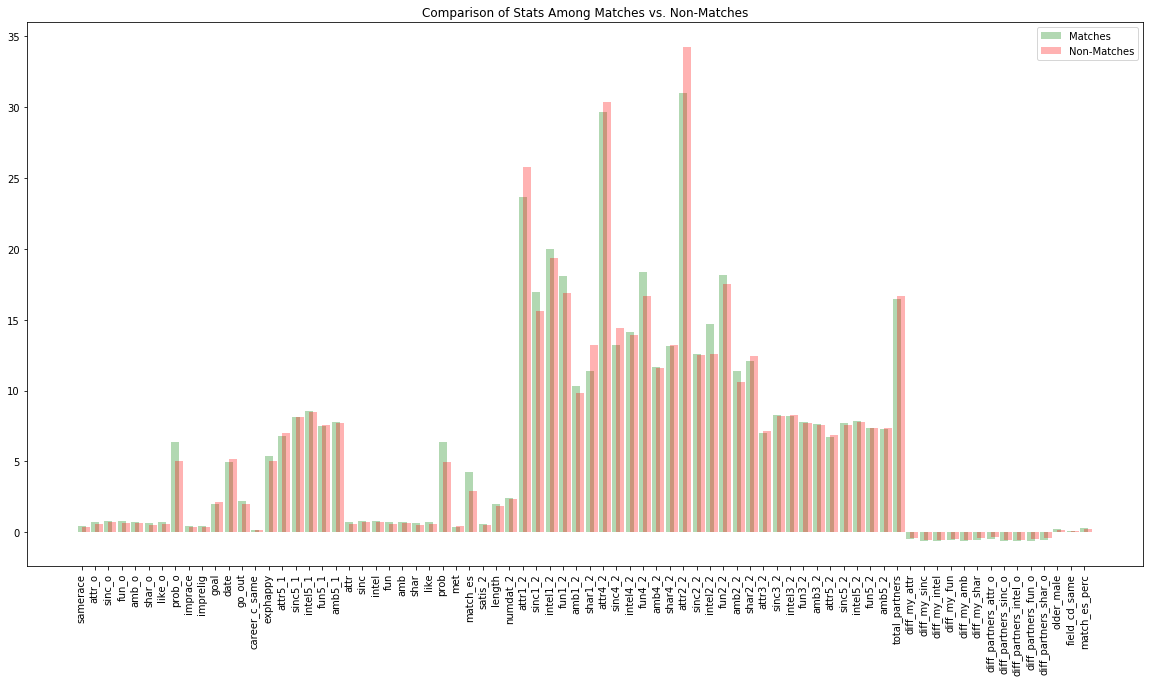

In [171]:
# More visualizations?
matches = new_df[new_df['match'] == 1]
non_matches = new_df[new_df['match'] == 0]

plt.figure(figsize=(20,10))

plt.bar(cols_of_interest, height=matches[cols_of_interest].mean(), width=0.6, color='green', alpha=0.3, label='Matches')
plt.bar(cols_of_interest, height=non_matches[cols_of_interest].mean(), width=0.6, color='red', align='edge', alpha=0.3, label='Non-Matches')
plt.title('Comparison of Stats Among Matches vs. Non-Matches')
plt.xticks(rotation=90)
plt.legend()

plt.show()

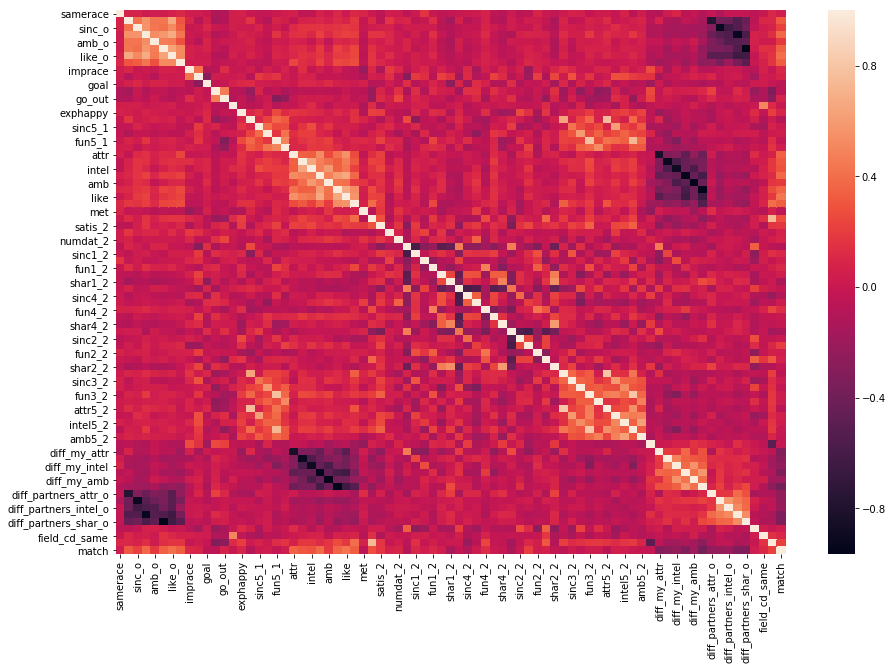

In [172]:
plt.figure(figsize=(15,10))
sns.heatmap(new_df.corr())
plt.show()

# Model for Target

Try several different approaches and work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. 

Think about explanatory versus predictive power and experiment with both.

In [173]:
def fit_and_train(model):
    model_fit = model.fit(X_train_res, Y_train_res)
    model_score_train = model.score(X_train, Y_train)
    print('R² for train:', model_score_train)
    
    model_score_test = model.score(X_test, Y_test)
    print('R² for test:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print('\n', test_crosstab)
    
    tI_errors = test_crosstab.loc[0,1] / test_crosstab.loc['All','All'] * 100
    tII_errors = test_crosstab.loc[1,0] / test_crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))

    precision = test_crosstab.loc[1,1] / test_crosstab.loc['All', 1] * 100 
    recall = test_crosstab.loc[1,1] / test_crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))
    
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)

lasso = linear_model.LogisticRegression(penalty='l1', C=10) 
fit_and_train(lasso)

# parametric vs non-parametric models 
# lasso is parametric – there are conventions; features should be norm.distributed; no multicollinearity
# lasso – will help with multicollinearity

R² for train: 0.840956340956341
R² for test: 0.8411214953271028

 predicted    0   1  All
actual                 
0          227  39  266
1           12  43   55
All        239  82  321

Type I errors: 12.15%
Type II errors: 3.74%

Precision: 52.44%
Recall: 78.18%

Coefficients: [[ 0.21393955  2.58260778 -5.64873319  3.0880878  -2.16606061  0.59253888
   4.30598761 -0.0128824   0.51915147  1.2426757  -0.39990751 -0.15300607
   0.60346708 -0.31130757 -0.32926148 -0.46186435 -0.43003435  0.60019614
   0.55005351 -0.01229041  3.56165439 -4.23154242  7.17358146  5.68004671
  -2.27691768 -6.91969106  6.83792597  0.28865763  0.10324629  0.062085
   0.82345849 -0.05760924 -0.42773323 -0.05268477  0.01848356 -0.03690962
  -0.10545999  0.0890318  -0.14254764  0.10297481  0.09587407  0.1343742
   0.15894684  0.00831561  0.11388534  0.10866862  0.05180554  0.24591771
   0.05556136  0.07548768  0.0720575  -0.06122939  0.03390684 -0.67769533
  -0.29231432 -0.2330827   0.28931512  0.53024057 -0.1260

R² for train: 0.9958419958419958
R² for test: 0.838006230529595

 predicted    0   1  All
actual                 
0          247  19  266
1           33  22   55
All        280  41  321

Type I errors: 5.92%
Type II errors: 10.28%

Precision: 53.66%
Recall: 40.0%
[0.01028404 0.02107233 0.00920014 0.08957631 0.01875713 0.04539471
 0.0646824  0.01005712 0.00401289 0.00618766 0.00182527 0.00662756
 0.00430293 0.00245673 0.00813839 0.00987841 0.00406333 0.00234173
 0.00306973 0.00508917 0.02911473 0.013489   0.01732211 0.10455957
 0.01202823 0.01060169 0.04762686 0.01431267 0.0055347  0.01634891
 0.01188135 0.00490776 0.0015493  0.01088817 0.00294748 0.00512513
 0.00510559 0.00135604 0.01103981 0.00216138 0.0118106  0.00309685
 0.00679513 0.00733934 0.00551654 0.00753734 0.00315088 0.01556586
 0.00901909 0.00736129 0.00605431 0.00672105 0.00631486 0.00386979
 0.00262307 0.00874673 0.00739614 0.0057907  0.0053625  0.01260139
 0.01228933 0.00758897 0.02479988 0.01356405 0.00958403 0.01715354

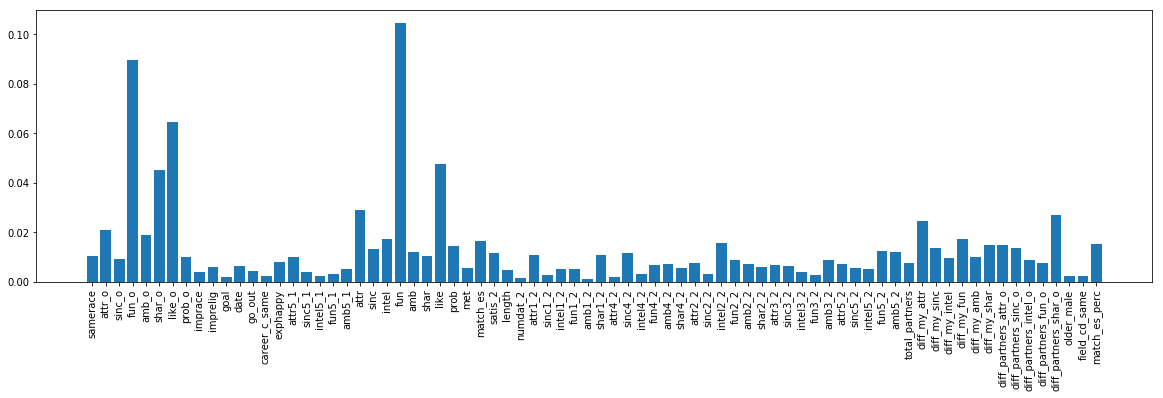

In [176]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc)
# LOOK AT FEATURE IMPORTANCES FOR RFC

plt.figure(figsize=(20,5))
print(rfc.feature_importances_)
plt.bar(X_train.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [174]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm)

R² for train: 0.9916839916839917
R² for test: 0.8504672897196262

 predicted    0   1  All
actual                 
0          247  19  266
1           29  26   55
All        276  45  321

Type I errors: 5.92%
Type II errors: 9.03%

Precision: 57.78%
Recall: 47.27%


In [175]:
svm = SVC(kernel='linear', probability=True)
fit_and_train(svm)

R² for train: 0.816008316008316
R² for test: 0.838006230529595

 predicted    0   1  All
actual                 
0          225  41  266
1           11  44   55
All        236  85  321

Type I errors: 12.77%
Type II errors: 3.43%

Precision: 51.76%
Recall: 80.0%

Coefficients: [[-6.01408161e-02  1.43521638e+00 -1.56502283e+00  1.68053809e+00
  -6.11753858e-01  9.18201823e-02  2.34745308e+00  4.04785091e-02
   2.12916109e-01  9.50252533e-01 -2.71863440e-01 -3.65717456e-02
   2.40366865e-01 -1.65721597e-01 -1.12319488e-01 -2.93909428e-01
  -1.50707110e-01  4.08908189e-01  2.48302234e-01 -8.14072368e-02
   1.75077594e+00 -4.37288751e-01  1.72624782e+00  7.65651913e-01
  -4.88843757e-01 -1.08485408e+00  3.64098108e+00  2.14610817e-01
   1.66763989e-01  1.55783931e-01  6.39194711e-01  5.35665498e-02
   7.94524608e-03 -3.89209846e-03  9.25387085e-03  1.44713819e-02
  -4.57284262e-02  6.65172255e-02 -8.72764713e-02  7.65075200e-02
   8.03124309e-02  7.75245792e-02  1.32749198e-01  1.84973938e

In [177]:
bnb = BernoulliNB()
fit_and_train(bnb)

R² for train: 0.5696465696465697
R² for test: 0.5919003115264797

 predicted    0    1  All
actual                  
0          158  108  266
1           23   32   55
All        181  140  321

Type I errors: 33.64%
Type II errors: 7.17%

Precision: 22.86%
Recall: 58.18%

Coefficients: [[-5.01655072e-01 -1.25707119e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -2.51572460e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.25707119e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.34688039e+00 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.25707119e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.25707119e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.25707119e-03 -1.25707119e-03 -1.25707119e-03
  -1.17834098e+00 -3.77596421e-03 -1.25707119e-03 -1.25707119e-03
  -1.25707119e-03 -1.25707119e-03 -1.26423934e-02 -1.25707119e-03
  -1.25707119e-03 -6.35340007e-02 -5.95259793e-02 -1.25707119e-03
  -2.67361565e-02 -1.90240360e-02 -2.03052662e-02 -3.7

In [165]:
# Make dummies for other categorical features and add to X and try models again

## Deliverables

Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

- A specified research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

You'll be presenting this slide deck live to a group as the culmination of your work in the last 2 supervised learning units. As a secondary matter, your slides and/or the Jupyter notebook you use or adapt them into should be worthy of inclusion as examples of your work product when applying to jobs.

In [27]:
#    Over Sampling: 
# Create two parts of whole datasets (original dataset having both frauds and no frauds) - train and  test
#  Oversample the fraud part of train dataset to make it 50% each fraud and non fraud. Split this dataset in train and test - call them Over_Sampled_train, Over_Sampled_test
#  train your tree based model on Over_Sampled_train and test it on Over_Sampled_test. record precision and recall.
#  Not test the above trained model on test dataset create at the start of over sampling. Record recision and recall.